## I. NEW Data Preparation

In this notebook, we shall prepare data to be used for inference.

These are the steps undertaken: 
1. Import libraries
2. Import datasets
3. Types of Variables
        3.1  Missing
        3.2 Outliers
            - Outliers in Continuous Variables
            - Outliers in Discrete Variables
        3.3 Number of tables: Cardinality
4. Pre-processing mixed type of variables
        4.1 Rare Labels in Categorical Variables
        4.2 See if there are outliers in newly created variables
5. Separate Training and Test Set
6. Engineering Outliers in Numerical Variables
        6.1 Top/Bottom Encoding
7. Engineer Categorical Variables
        7.1 Engineer Rare Labels
        7.2 Engineer labels in Categorical Variables
8. Gaussian Transformation
9. Scaling (Robust, MinMax, Standard)
10. Put selected variables in one dataset and save



### 1.Importing libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

import pylab 
import scipy.stats as stats

#Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler





### 2. Import datasets 

In [2]:
df=pd.read_csv('Credit-Scoring-Clean.csv')
df.shape

(950, 21)

In [3]:
# REmove duplicate columns if any
#Remove duplicate columns
_, i = np.unique(df.columns, return_index=True)
df=df.iloc[:, i]
df.shape

(950, 21)

We can see there were no duplicate rows

In [4]:
df.head()

,Age,CheckingAcctStat,CreditAmount,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone
0,0.089286,A11,0.161770,A32,1,0.205882,A73,0.0,A201,A152,0.333333,A173,0.0,A101,A143,0.333333,A121,A43,A61,A92,A191
1,0.125000,A14,0.058380,A32,0,0.294118,A74,0.0,A201,A152,1.000000,A173,0.0,A101,A143,0.666667,A122,A43,A62,A94,A192
2,0.232143,A14,0.069055,A32,0,0.205882,A73,0.0,A201,A153,1.000000,A174,0.0,A101,A143,0.333333,A124,A43,A61,A93,A192
3,0.214286,A11,0.358094,A32,1,0.647059,A73,0.0,A201,A152,0.666667,A173,0.0,A101,A143,0.333333,A123,A43,A61,A92,A192
4,0.178571,A13,0.023825,A33,0,0.029412,A72,0.0,A201,A152,0.333333,A173,0.0,A101,A141,0.000000,A122,A43,A61,A92,A191


### 3. Types of Variables

In [5]:
df.dtypes

Age                      float64
CheckingAcctStat          object
CreditAmount             float64
CreditHistory             object
CreditStatus               int64
Duration                 float64
Employment                object
ExistingCreditsAtBank    float64
ForeignWorker             object
Housing                   object
InstallmentRatePecnt     float64
Job                       object
NumberDependents         float64
OtherDetorsGuarantors     object
OtherInstalments          object
PresentResidenceTime     float64
Property                  object
Purpose                   object
Savings                   object
SexAndStatus              object
Telephone                 object
dtype: object

There are a mixture of categorical and numerical variables. Numerical are those of type int and float. Categorical those of type object.

In [6]:
# find numerical variables
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 8 numerical variables


In [7]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 13 categorical variables


In [8]:
# view of categorical variables
df[categorical].head()

,CheckingAcctStat,CreditHistory,Employment,ForeignWorker,Housing,Job,OtherDetorsGuarantors,OtherInstalments,Property,Purpose,Savings,SexAndStatus,Telephone
0,A11,A32,A73,A201,A152,A173,A101,A143,A121,A43,A61,A92,A191
1,A14,A32,A74,A201,A152,A173,A101,A143,A122,A43,A62,A94,A192
2,A14,A32,A73,A201,A153,A174,A101,A143,A124,A43,A61,A93,A192
3,A11,A32,A73,A201,A152,A173,A101,A143,A123,A43,A61,A92,A192
4,A13,A33,A72,A201,A152,A173,A101,A141,A122,A43,A61,A92,A191


In [9]:
df[categorical].columns

Index(['CheckingAcctStat', 'CreditHistory', 'Employment', 'ForeignWorker',
       'Housing', 'Job', 'OtherDetorsGuarantors', 'OtherInstalments',
       'Property', 'Purpose', 'Savings', 'SexAndStatus', 'Telephone'],
      dtype='object')

* It looks like all categorical variables are potentially mixed type variables, since they contain both numbers and letters.
* We could extract the numerical part and then the non-numerical part and generate 2 variables out of them, to see if that adds value to our predictive models.

In [10]:
# view of numerical variables
df[numerical].head(20)

,Age,CreditAmount,CreditStatus,Duration,ExistingCreditsAtBank,InstallmentRatePecnt,NumberDependents,PresentResidenceTime
0,0.089286,0.161770,1,0.205882,0.000000,0.333333,0.0,0.333333
1,0.125000,0.058380,0,0.294118,0.000000,1.000000,0.0,0.666667
2,0.232143,0.069055,0,0.205882,0.000000,1.000000,0.0,0.333333
3,0.214286,0.358094,1,0.647059,0.000000,0.666667,0.0,0.333333
4,0.178571,0.023825,0,0.029412,0.000000,0.333333,0.0,0.000000
5,0.446429,0.131892,0,0.029412,0.000000,0.333333,1.0,0.666667
6,0.196429,0.088808,1,0.205882,0.333333,1.000000,0.0,0.333333
7,0.035714,0.035875,1,0.117647,0.000000,1.000000,0.0,1.000000
8,0.357143,0.022890,0,0.029412,0.333333,0.666667,0.0,1.000000
9,0.017857,0.108452,0,0.161765,0.000000,0.333333,0.0,1.000000


* 6 Continuous variables: Age, CreditAmount, Duration, ExistingCreditsAtBank, InstallmentRatePecnt, PresentREsidenceTime
* 1 Binary Variable: Credit Status (which is the LABEL or TARGET we want to predict)

#### 3.1 Missing Values

In [11]:
# let's visualise the percentage of missing values
df.isnull().mean()

Age                      0.0
CheckingAcctStat         0.0
CreditAmount             0.0
CreditHistory            0.0
CreditStatus             0.0
Duration                 0.0
Employment               0.0
ExistingCreditsAtBank    0.0
ForeignWorker            0.0
Housing                  0.0
InstallmentRatePecnt     0.0
Job                      0.0
NumberDependents         0.0
OtherDetorsGuarantors    0.0
OtherInstalments         0.0
PresentResidenceTime     0.0
Property                 0.0
Purpose                  0.0
Savings                  0.0
SexAndStatus             0.0
Telephone                0.0
dtype: float64

Great! I have no nulls!

#### 3.2 Outliers

In [12]:
numerical = [var for var in numerical if var not in['CreditStatus']]
numerical

['Age',
 'CreditAmount',
 'Duration',
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'NumberDependents',
 'PresentResidenceTime']

**Outliers in Continuous variables**

Let's find the outliers in the 6 continuous variables: 
Age, CreditAmount, Duration, ExistingCreditsAtBank, InstallmentRatePecnt, PresentREsidenceTime

Text(0, 0.5, 'CreditAmount')

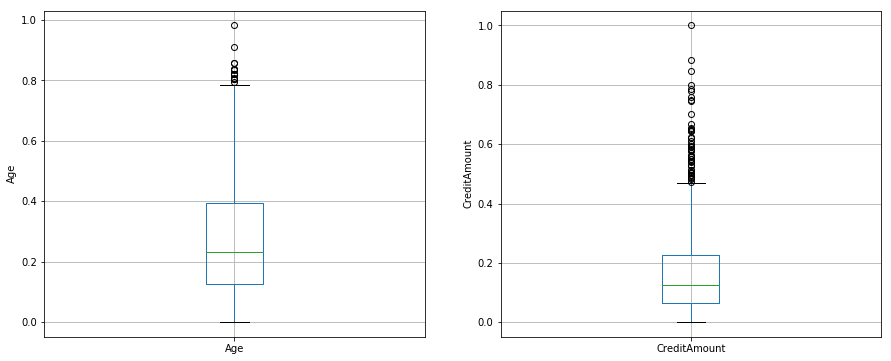

In [13]:
# let's make boxplots to visualise outliers in the continuous variables 
# Age, CreditAmount, Duration, ExistingCreditsAtBank, InstallmentRatePecnt, PresentREsidenceTime

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.boxplot(column='Age')
fig.set_title('')
fig.set_ylabel('Age')

plt.subplot(1, 2, 2)
fig = df.boxplot(column='CreditAmount')
fig.set_title('')
fig.set_ylabel('CreditAmount')


Text(0, 0.5, 'ExistingCreditsAtBank')

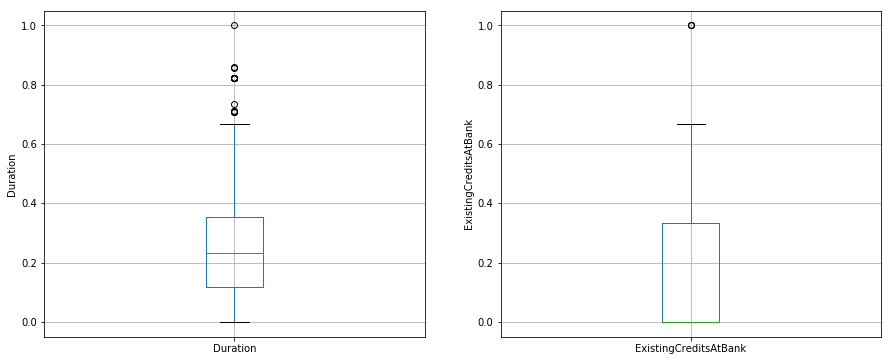

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.boxplot(column='Duration')
fig.set_title('')
fig.set_ylabel('Duration')

plt.subplot(1, 2, 2)
fig = df.boxplot(column='ExistingCreditsAtBank')
fig.set_title('')
fig.set_ylabel('ExistingCreditsAtBank')


Text(0, 0.5, 'PresentResidenceTime')

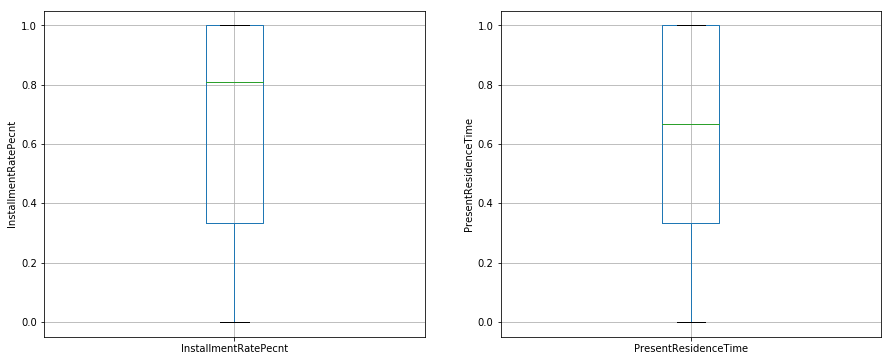

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.boxplot(column='InstallmentRatePecnt')
fig.set_title('')
fig.set_ylabel('InstallmentRatePecnt')

plt.subplot(1, 2, 2)
fig = df.boxplot(column='PresentResidenceTime')
fig.set_title('')
fig.set_ylabel('PresentResidenceTime')

4 out of the 6 continuous variables have outliers: Age, CreditAmount, Duration, ExistingCreditsAtBank

Let's find out which are outliers

Text(0.5, 0, 'CreditAmount')

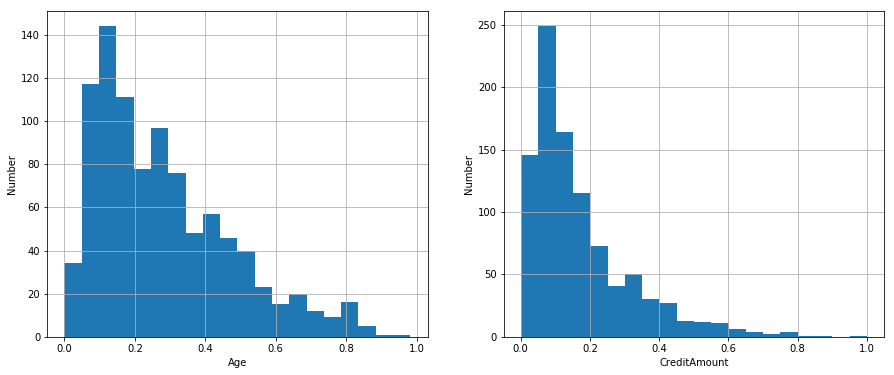

In [16]:
# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.Age.hist(bins=20)
fig.set_ylabel('Number')
fig.set_xlabel('Age')

plt.subplot(1, 2, 2)
fig = df.CreditAmount.hist(bins=20)
fig.set_ylabel('Number')
fig.set_xlabel('CreditAmount')

Text(0.5, 0, 'ExistingCreditsAtBank')

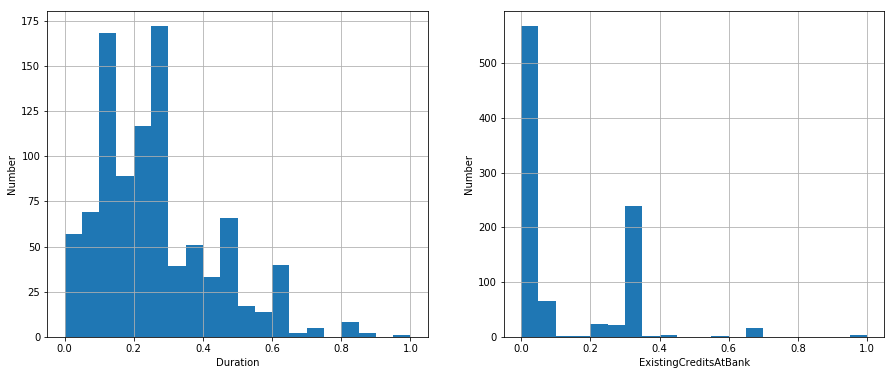

In [17]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = df.Duration.hist(bins=20)
fig.set_ylabel('Number')
fig.set_xlabel('Duration')

plt.subplot(1, 2, 2)
fig = df.ExistingCreditsAtBank.hist(bins=20)
fig.set_ylabel('Number')
fig.set_xlabel('ExistingCreditsAtBank')

All 4 continuous variables seem to have a skewed distribution, so I shall use the IQR method to find the outliers

In [18]:
# find outliers

# Age
IQR = df.Age.quantile(0.75) - df.Age.quantile(0.25)
Lower_fence = df.Age.quantile(0.25) - (IQR * 3)
Upper_fence = df.Age.quantile(0.75) + (IQR * 3)
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# CreditAmount
IQR = df.CreditAmount.quantile(0.75) - df.CreditAmount.quantile(0.25)
Lower_fence = df.CreditAmount.quantile(0.25) - (IQR * 3)
Upper_fence = df.CreditAmount.quantile(0.75) + (IQR * 3)
print('CreditAmount outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Duration
IQR = df.Duration.quantile(0.75) - df.Duration.quantile(0.25)
Lower_fence = df.Duration.quantile(0.25) - (IQR * 3)
Upper_fence = df.Duration.quantile(0.75) + (IQR * 3)
print('Duration outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# ExistingCreditsAtBank
IQR = df.ExistingCreditsAtBank.quantile(0.75) - df.ExistingCreditsAtBank.quantile(0.25)
Lower_fence = df.ExistingCreditsAtBank.quantile(0.25) - (IQR * 3)
Upper_fence = df.ExistingCreditsAtBank.quantile(0.75) + (IQR * 3)
print('ExistingCreditsAtBank outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


Age outliers are values < -0.6724138319999998 or > 1.1918103742499997
CreditAmount outliers are values < -0.42554058225 or > 0.7159834115
Duration outliers are values < -0.588235292 or > 1.0588235270000002
ExistingCreditsAtBank outliers are values < -0.999999999 or > 1.333333332


Now I have identied the outliers in the continuous variables. I will have to deal with them later

#### 3.3 Number of labels: Cardinality

In [19]:
for var in categorical:
    print(var, ' contains ', len(df[var].unique()), ' labels')

CheckingAcctStat  contains  4  labels
CreditHistory  contains  5  labels
Employment  contains  5  labels
ForeignWorker  contains  2  labels
Housing  contains  3  labels
Job  contains  4  labels
OtherDetorsGuarantors  contains  3  labels
OtherInstalments  contains  3  labels
Property  contains  4  labels
Purpose  contains  10  labels
Savings  contains  5  labels
SexAndStatus  contains  4  labels
Telephone  contains  2  labels


None of them seems to present really high cardinality. Purpose is the one with the highest cardinality with a number of 10 labels.
On the other hand, all these categorical labels are mixed labels, so Is hall have to deal with them before proceediing with data exploration. 

### 4. Preprocessing mixed type of variables

All categorical variables contain both number and letters. I shall create 2 variable sfor each extracting the numerical and categorical part. 

In [20]:
df.head()

,Age,CheckingAcctStat,CreditAmount,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone
0,0.089286,A11,0.161770,A32,1,0.205882,A73,0.0,A201,A152,0.333333,A173,0.0,A101,A143,0.333333,A121,A43,A61,A92,A191
1,0.125000,A14,0.058380,A32,0,0.294118,A74,0.0,A201,A152,1.000000,A173,0.0,A101,A143,0.666667,A122,A43,A62,A94,A192
2,0.232143,A14,0.069055,A32,0,0.205882,A73,0.0,A201,A153,1.000000,A174,0.0,A101,A143,0.333333,A124,A43,A61,A93,A192
3,0.214286,A11,0.358094,A32,1,0.647059,A73,0.0,A201,A152,0.666667,A173,0.0,A101,A143,0.333333,A123,A43,A61,A92,A192
4,0.178571,A13,0.023825,A33,0,0.029412,A72,0.0,A201,A152,0.333333,A173,0.0,A101,A141,0.000000,A122,A43,A61,A92,A191


In [21]:
# CheckingAcctStat#
df['CheckingAcctStat_num'] = df.CheckingAcctStat.str.extract('(\d+)') # extracts number from string
df['CheckingAcctStat_num'] = df['CheckingAcctStat_num'].astype('float') # parses the above variable to float type
df['CheckingAcctStat_cat'] = df['CheckingAcctStat'].str[0] # captures first letter of string (the letter of the cabin)

df[['CheckingAcctStat','CheckingAcctStat_num','CheckingAcctStat_cat']].head()

# CreditHistory#
df['CreditHistory_num'] = df.CreditHistory.str.extract('(\d+)') # extracts number from string
df['CreditHistory_num'] = df['CreditHistory_num'].astype('float') # parses the above variable to float type
df['CreditHistory_cat'] = df['CreditHistory'].str[0] # captures first letter of string (the letter of the cabin)

df[['CreditHistory','CreditHistory_num','CreditHistory_cat']].head()

# Employment#
df['Employment_num'] = df.Employment.str.extract('(\d+)') # extracts number from string
df['Employment_num'] = df['Employment_num'].astype('float') # parses the above variable to float type
df['Employment_cat'] = df['Employment'].str[0] # captures first letter of string (the letter of the cabin)

df[['Employment','Employment_num','Employment_cat']].head()

# ForeignWorker#
df['ForeignWorker_num'] = df.ForeignWorker.str.extract('(\d+)') # extracts number from string
df['ForeignWorker_num'] = df['ForeignWorker_num'].astype('float') # parses the above variable to float type
df['ForeignWorker_cat'] = df['ForeignWorker'].str[0] # captures first letter of string (the letter of the cabin)

df[['ForeignWorker','ForeignWorker_num','ForeignWorker_cat']].head()

# Housing#
df['Housing_num'] = df.Housing.str.extract('(\d+)') # extracts number from string
df['Housing_num'] = df['Housing_num'].astype('float') # parses the above variable to float type
df['Housing_cat'] = df['Housing'].str[0] # captures first letter of string (the letter of the cabin)

df[['Housing','Housing_num','Housing_cat']].head()

# Job#
df['Job_num'] = df.Job.str.extract('(\d+)') # extracts number from string
df['Job_num'] = df['Job_num'].astype('float') # parses the above variable to float type
df['Job_cat'] = df['Job'].str[0] # captures first letter of string (the letter of the cabin)

df[['Job','Job_num','Job_cat']].head()

# OtherDetorsGuarantors#
df['OtherDetorsGuarantors_num'] = df.OtherDetorsGuarantors.str.extract('(\d+)') # extracts number from string
df['OtherDetorsGuarantors_num'] = df['OtherDetorsGuarantors_num'].astype('float') # parses the above variable to float type
df['OtherDetorsGuarantors_cat'] = df['OtherDetorsGuarantors'].str[0] # captures first letter of string (the letter of the cabin)

df[['OtherDetorsGuarantors','OtherDetorsGuarantors_num','OtherDetorsGuarantors_cat']].head()

# OtherInstalments#
df['OtherInstalments_num'] = df.OtherInstalments.str.extract('(\d+)') # extracts number from string
df['OtherInstalments_num'] = df['OtherInstalments_num'].astype('float') # parses the above variable to float type
df['OtherInstalments_cat'] = df['OtherInstalments'].str[0] # captures first letter of string (the letter of the cabin)

df[['OtherInstalments','OtherInstalments_num','OtherInstalments_cat']].head()

# Property#
df['Property_num'] = df.Property.str.extract('(\d+)') # extracts number from string
df['Property_num'] = df['Property_num'].astype('float') # parses the above variable to float type
df['Property_cat'] = df['Property'].str[0] # captures first letter of string (the letter of the cabin)

df[['Property','Property_num','Property_cat']].head()

# Purpose#
df['Purpose_num'] = df.Purpose.str.extract('(\d+)') # extracts number from string
df['Purpose_num'] = df['Purpose_num'].astype('float') # parses the above variable to float type
df['Purpose_cat'] = df['Purpose'].str[0] # captures first letter of string (the letter of the cabin)

df[['Purpose','Purpose_num','Purpose_cat']].head()

# Savings#
df['Savings_num'] = df.Savings.str.extract('(\d+)') # extracts number from string
df['Savings_num'] = df['Savings_num'].astype('float') # parses the above variable to float type
df['Savings_cat'] = df['Savings'].str[0] # captures first letter of string (the letter of the cabin)

df[['Savings','Savings_num','Savings_cat']].head()

# SexAndStatus#
df['SexAndStatus_num'] = df.SexAndStatus.str.extract('(\d+)') # extracts number from string
df['SexAndStatus_num'] = df['SexAndStatus_num'].astype('float') # parses the above variable to float type
df['SexAndStatus_cat'] = df['SexAndStatus'].str[0] # captures first letter of string (the letter of the cabin)

df[['SexAndStatus','SexAndStatus_num','SexAndStatus_cat']].head()

# Telephone#
df['Telephone_num'] = df.Telephone.str.extract('(\d+)') # extracts number from string
df['Telephone_num'] = df['Telephone_num'].astype('float') # parses the above variable to float type
df['Telephone_cat'] = df['Telephone'].str[0] # captures first letter of string (the letter of the cabin)

df[['Telephone','Telephone_num','Telephone_cat']].head()



df[['CheckingAcctStat','CheckingAcctStat_num','CheckingAcctStat_cat',
   'CreditHistory','CreditHistory_num','CreditHistory_cat',
   'Employment','Employment_num','Employment_cat',
   'ForeignWorker','ForeignWorker_num','ForeignWorker_cat',
   'Housing','Housing_num','Housing_cat',
   'Job','Job_num','Job_cat',
   'OtherDetorsGuarantors','OtherDetorsGuarantors_num','OtherDetorsGuarantors_cat',
   'OtherInstalments','OtherInstalments_num','OtherInstalments_cat',
   'Property','Property_num','Property_cat',
   'Purpose','Purpose_num','Purpose_cat',
   'Savings','Savings_num','Savings_cat',
   'SexAndStatus','SexAndStatus_num','SexAndStatus_cat',
   'Telephone','Telephone_num','Telephone_cat']].head()


,CheckingAcctStat,CheckingAcctStat_num,CheckingAcctStat_cat,CreditHistory,CreditHistory_num,CreditHistory_cat,Employment,Employment_num,Employment_cat,ForeignWorker,ForeignWorker_num,ForeignWorker_cat,Housing,Housing_num,Housing_cat,Job,Job_num,Job_cat,OtherDetorsGuarantors,OtherDetorsGuarantors_num,OtherDetorsGuarantors_cat,OtherInstalments,OtherInstalments_num,OtherInstalments_cat,Property,Property_num,Property_cat,Purpose,Purpose_num,Purpose_cat,Savings,Savings_num,Savings_cat,SexAndStatus,SexAndStatus_num,SexAndStatus_cat,Telephone,Telephone_num,Telephone_cat
0,A11,11.0,A,A32,32.0,A,A73,73.0,A,A201,201.0,A,A152,152.0,A,A173,173.0,A,A101,101.0,A,A143,143.0,A,A121,121.0,A,A43,43.0,A,A61,61.0,A,A92,92.0,A,A191,191.0,A
1,A14,14.0,A,A32,32.0,A,A74,74.0,A,A201,201.0,A,A152,152.0,A,A173,173.0,A,A101,101.0,A,A143,143.0,A,A122,122.0,A,A43,43.0,A,A62,62.0,A,A94,94.0,A,A192,192.0,A
2,A14,14.0,A,A32,32.0,A,A73,73.0,A,A201,201.0,A,A153,153.0,A,A174,174.0,A,A101,101.0,A,A143,143.0,A,A124,124.0,A,A43,43.0,A,A61,61.0,A,A93,93.0,A,A192,192.0,A
3,A11,11.0,A,A32,32.0,A,A73,73.0,A,A201,201.0,A,A152,152.0,A,A173,173.0,A,A101,101.0,A,A143,143.0,A,A123,123.0,A,A43,43.0,A,A61,61.0,A,A92,92.0,A,A192,192.0,A
4,A13,13.0,A,A33,33.0,A,A72,72.0,A,A201,201.0,A,A152,152.0,A,A173,173.0,A,A101,101.0,A,A141,141.0,A,A122,122.0,A,A43,43.0,A,A61,61.0,A,A92,92.0,A,A191,191.0,A


In [22]:
df.dtypes

Age                          float64
CheckingAcctStat              object
CreditAmount                 float64
CreditHistory                 object
CreditStatus                   int64
Duration                     float64
Employment                    object
ExistingCreditsAtBank        float64
ForeignWorker                 object
Housing                       object
InstallmentRatePecnt         float64
Job                           object
NumberDependents             float64
OtherDetorsGuarantors         object
OtherInstalments              object
PresentResidenceTime         float64
Property                      object
Purpose                       object
Savings                       object
SexAndStatus                  object
Telephone                     object
CheckingAcctStat_num         float64
CheckingAcctStat_cat          object
CreditHistory_num            float64
CreditHistory_cat             object
Employment_num               float64
Employment_cat                object
F

In [23]:
# drop the original variable
df= df.drop(['CheckingAcctStat','CreditHistory','Employment','ForeignWorker','Housing', 'Job', 'OtherDetorsGuarantors', 'OtherInstalments','Property', 'Purpose', 'Savings', 'SexAndStatus', 'Telephone'], axis=1)

In [24]:
df.shape

(950, 34)

#### 4.1 Rare Labels in Categorial Variables

Note, I also have to add to the categorical variables the Numerical Discrete variables: NumberDependents


In [25]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 13 categorical variables


In [26]:
categorical

['CheckingAcctStat_cat',
 'CreditHistory_cat',
 'Employment_cat',
 'ForeignWorker_cat',
 'Housing_cat',
 'Job_cat',
 'OtherDetorsGuarantors_cat',
 'OtherInstalments_cat',
 'Property_cat',
 'Purpose_cat',
 'Savings_cat',
 'SexAndStatus_cat',
 'Telephone_cat']

In [27]:
# rare / infrequent labels (less than 1%)
for var in ['CheckingAcctStat_cat',
'CreditHistory_cat',
'Employment_cat',
'ForeignWorker_cat',
'Housing_cat',
'Job_cat',
'OtherDetorsGuarantors_cat',
'OtherInstalments_cat',
'Property_cat',
'Purpose_cat',
'Savings_cat',
'SexAndStatus_cat',
'Telephone_cat', 'NumberDependents']:
    print(df[var].value_counts() / np.float(len(df)))
    print()

A    1.0
Name: CheckingAcctStat_cat, dtype: float64

A    1.0
Name: CreditHistory_cat, dtype: float64

A    1.0
Name: Employment_cat, dtype: float64

A    1.0
Name: ForeignWorker_cat, dtype: float64

A    1.0
Name: Housing_cat, dtype: float64

A    1.0
Name: Job_cat, dtype: float64

A    1.0
Name: OtherDetorsGuarantors_cat, dtype: float64

A    1.0
Name: OtherInstalments_cat, dtype: float64

A    1.0
Name: Property_cat, dtype: float64

A    1.0
Name: Purpose_cat, dtype: float64

A    1.0
Name: Savings_cat, dtype: float64

A    1.0
Name: SexAndStatus_cat, dtype: float64

A    1.0
Name: Telephone_cat, dtype: float64

0.000000    0.815789
1.000000    0.152632
0.934024    0.010526
0.143863    0.010526
0.856137    0.005263
0.065976    0.005263
Name: NumberDependents, dtype: float64



Well, I have no rare values. 

I have rare values on NumberDependents variables, they represent less than 5% per the variable so I shall do median imputation

On the other hand, I have 13 constant variable (1 value), I shall delete them as they bring no value

#### 4.2 See if there are outliers in newly created variables

First I will see if the newly created variables follow a normal distribution.

I will do it looking at their Kurtosis, normal distribution tend to have kurtosis values between 0 and 1. Else the variable is considered to be skewed. 

In [28]:
for var in ['CheckingAcctStat_num',
'CreditHistory_num',
'Employment_num',
'ForeignWorker_num',
'Housing_num',
'Job_num',
'OtherDetorsGuarantors_num',
'OtherInstalments_num',
'Property_num',
'Purpose_num',
'Savings_num',
'SexAndStatus_num',
'Telephone_num']:
    print(var, 'skewness is', df[var].skew() )


CheckingAcctStat_num skewness is 0.324403394293832
CreditHistory_num skewness is 0.04254048672051838
Employment_num skewness is -0.04559677032830854
ForeignWorker_num skewness is 6.060130757010168
Housing_num skewness is -0.03802905332277845
Job_num skewness is -0.36766902316678163
OtherDetorsGuarantors_num skewness is 3.3234216286090854
OtherInstalments_num skewness is -1.9018042230766536
Property_num skewness is -0.04308641795574535
Purpose_num skewness is 9.079409486156203
Savings_num skewness is 1.2626891823986097
SexAndStatus_num skewness is -0.14999183148514458
Telephone_num skewness is 0.42237154939797195


Some variables have a skweness between 0 and 1, which is normal. 

Skewed variables are those with an absolute skewness value above 1:
    
    - ForeignWorkerNum
    - OtherDetorsGuarantors_num
    - OtherInstalments_num
    - Purpose_num
    - Savings_num

Let's find outliers using IQR

Text(0, 0.5, 'Job_num')

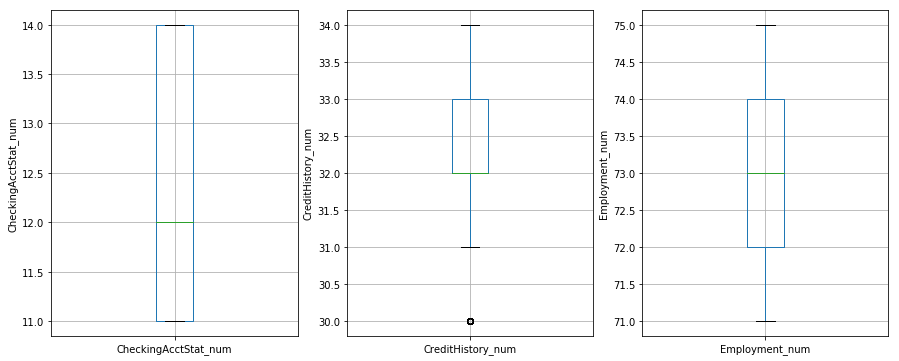

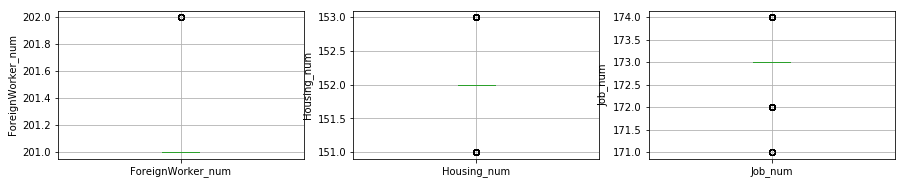

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
fig = df.boxplot(column='CheckingAcctStat_num')
fig.set_title('')
fig.set_ylabel('CheckingAcctStat_num')

plt.subplot(1, 3, 2)
fig = df.boxplot(column='CreditHistory_num')
fig.set_title('')
fig.set_ylabel('CreditHistory_num')

plt.subplot(1, 3, 3)
fig = df.boxplot(column='Employment_num')
fig.set_title('')
fig.set_ylabel('Employment_num')

plt.figure(figsize=(15,6))
plt.subplot(2, 3, 1)
fig = df.boxplot(column='ForeignWorker_num')
fig.set_title('')
fig.set_ylabel('ForeignWorker_num')

plt.subplot(2, 3, 2)
fig = df.boxplot(column='Housing_num')
fig.set_title('')
fig.set_ylabel('Housing_num')

plt.subplot(2, 3, 3)
fig = df.boxplot(column='Job_num')
fig.set_title('')
fig.set_ylabel('Job_num')




Text(0, 0.5, 'SexAndStatus_num')

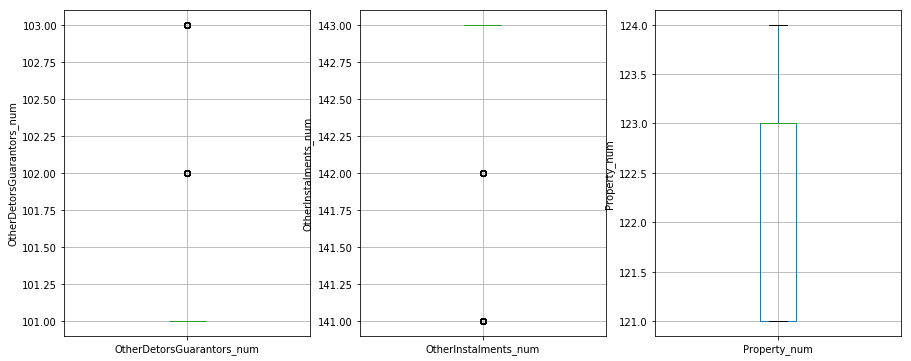

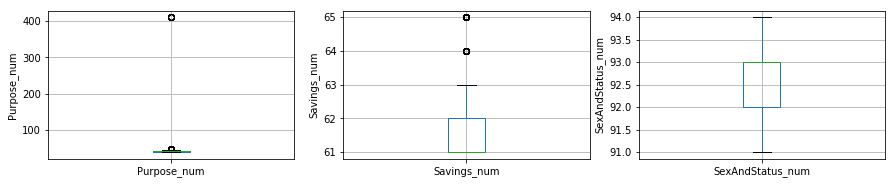

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
fig = df.boxplot(column='OtherDetorsGuarantors_num')
fig.set_title('')
fig.set_ylabel('OtherDetorsGuarantors_num')

plt.subplot(1, 3, 2)
fig = df.boxplot(column='OtherInstalments_num')
fig.set_title('')
fig.set_ylabel('OtherInstalments_num')

plt.subplot(1, 3, 3)
fig = df.boxplot(column='Property_num')
fig.set_title('')
fig.set_ylabel('Property_num')

plt.figure(figsize=(15,6))
plt.subplot(2, 3, 1)
fig = df.boxplot(column='Purpose_num')
fig.set_title('')
fig.set_ylabel('Purpose_num')

plt.subplot(2, 3, 2)
fig = df.boxplot(column='Savings_num')
fig.set_title('')
fig.set_ylabel('Savings_num')

plt.subplot(2, 3, 3)
fig = df.boxplot(column='SexAndStatus_num')
fig.set_title('')
fig.set_ylabel('SexAndStatus_num')

Text(0, 0.5, 'Telephone_num')

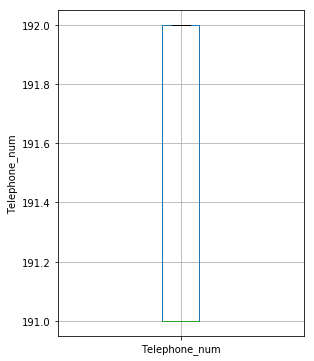

In [31]:
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
fig = df.boxplot(column='Telephone_num')
fig.set_title('')
fig.set_ylabel('Telephone_num')



#### The following newly created columns present ouliers:
- CreditHist_num
- ForeignWorker_num
- Housing_num
- Job_num
- OtherDetorsGurantors_num
- OhterInstalments_num
- Puprose_num
- Savings_num
- SexAndStatus_num
- NumberDependents


In [32]:
# find outliers

# CreditHistory_num
IQR = df.CreditHistory_num.quantile(0.75) - df.CreditHistory_num.quantile(0.25)
Lower_fence = df.CreditHistory_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.CreditHistory_num.quantile(0.75) + (IQR * 3)
print('CreditHistory_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# ForeignWorker_num
IQR = df.ForeignWorker_num.quantile(0.75) - df.ForeignWorker_num.quantile(0.25)
Lower_fence = df.ForeignWorker_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.ForeignWorker_num.quantile(0.75) + (IQR * 3)
print('ForeignWorker_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Housing_num
IQR = df.Housing_num.quantile(0.75) - df.Housing_num.quantile(0.25)
Lower_fence = df.Housing_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Housing_num.quantile(0.75) + (IQR * 3)
print('Housing_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Job_num
IQR = df.Job_num.quantile(0.75) - df.Job_num.quantile(0.25)
Lower_fence = df.Job_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Job_num.quantile(0.75) + (IQR * 3)
print('Job_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# OtherDetorsGuarantors_num
IQR = df.OtherDetorsGuarantors_num.quantile(0.75) - df.OtherDetorsGuarantors_num.quantile(0.25)
Lower_fence = df.OtherDetorsGuarantors_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.OtherDetorsGuarantors_num.quantile(0.75) + (IQR * 3)
print('OtherDetorsGuarantors_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# OtherInstalments_num
IQR = df.OtherInstalments_num.quantile(0.75) - df.OtherInstalments_num.quantile(0.25)
Lower_fence = df.OtherInstalments_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.OtherInstalments_num.quantile(0.75) + (IQR * 3)
print('OtherInstalments_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Purpose_num
IQR = df.Job_num.quantile(0.75) - df.Job_num.quantile(0.25)
Lower_fence = df.Job_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Job_num.quantile(0.75) + (IQR * 3)
print('OtherInstalments_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Savings_num
IQR = df.Savings_num.quantile(0.75) - df.Savings_num.quantile(0.25)
Lower_fence = df.Savings_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Savings_num.quantile(0.75) + (IQR * 3)
print('Savings_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# SexAndStatus_num
IQR = df.SexAndStatus_num.quantile(0.75) - df.SexAndStatus_num.quantile(0.25)
Lower_fence = df.SexAndStatus_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.SexAndStatus_num.quantile(0.75) + (IQR * 3)
print('SexAndStatus_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# SexAndStatus_num
IQR = df.NumberDependents.quantile(0.75) - df.NumberDependents.quantile(0.25)
Lower_fence = df.NumberDependents.quantile(0.25) - (IQR * 3)
Upper_fence = df.NumberDependents.quantile(0.75) + (IQR * 3)
print('NumberDependents outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))





CreditHistory_num outliers are values < 29.0 or > 36.0
ForeignWorker_num outliers are values < 201.0 or > 201.0
Housing_num outliers are values < 152.0 or > 152.0
Job_num outliers are values < 173.0 or > 173.0
OtherDetorsGuarantors_num outliers are values < 101.0 or > 101.0
OtherInstalments_num outliers are values < 143.0 or > 143.0
OtherInstalments_num outliers are values < 173.0 or > 173.0
Savings_num outliers are values < 58.0 or > 65.0
SexAndStatus_num outliers are values < 89.0 or > 96.0
NumberDependents outliers are values < 0.0 or > 0.0


### 5. Separate train and test set

In [33]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(df, df.CreditStatus, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((760, 34), (190, 34))

In [34]:
# let's group again the variables into categorical or numerical
# now considering the newly created variables

def find_categorical_and_numerical_variables(dataframe):
    cat_vars = [col for col in df.columns if df[col].dtypes == 'O']
    num_vars  = [col for col in df.columns if df[col].dtypes != 'O']
    return cat_vars, num_vars
                 
categorical, numerical = find_categorical_and_numerical_variables(df)       

In [35]:
categorical

['CheckingAcctStat_cat',
 'CreditHistory_cat',
 'Employment_cat',
 'ForeignWorker_cat',
 'Housing_cat',
 'Job_cat',
 'OtherDetorsGuarantors_cat',
 'OtherInstalments_cat',
 'Property_cat',
 'Purpose_cat',
 'Savings_cat',
 'SexAndStatus_cat',
 'Telephone_cat']

In [36]:
numerical = [var for var in numerical if var not in ['Survived','PassengerId']]
numerical

['Age',
 'CreditAmount',
 'CreditStatus',
 'Duration',
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'NumberDependents',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'ForeignWorker_num',
 'Housing_num',
 'Job_num',
 'OtherDetorsGuarantors_num',
 'OtherInstalments_num',
 'Property_num',
 'Purpose_num',
 'Savings_num',
 'SexAndStatus_num',
 'Telephone_num']

In [37]:
df.isnull().sum()

Age                          0
CreditAmount                 0
CreditStatus                 0
Duration                     0
ExistingCreditsAtBank        0
InstallmentRatePecnt         0
NumberDependents             0
PresentResidenceTime         0
CheckingAcctStat_num         0
CheckingAcctStat_cat         0
CreditHistory_num            0
CreditHistory_cat            0
Employment_num               0
Employment_cat               0
ForeignWorker_num            0
ForeignWorker_cat            0
Housing_num                  0
Housing_cat                  0
Job_num                      0
Job_cat                      0
OtherDetorsGuarantors_num    0
OtherDetorsGuarantors_cat    0
OtherInstalments_num         0
OtherInstalments_cat         0
Property_num                 0
Property_cat                 0
Purpose_num                  0
Purpose_cat                  0
Savings_num                  0
Savings_cat                  0
SexAndStatus_num             0
SexAndStatus_cat             0
Telephon

### 6. Engineer Outliers in Numerical Variables

Numerical variables with outliers are: 
    
- Age
- CreditAmount
- Duration
- ExistingCreditsAtBank
- CreditHist_num
- ForeignWorker_num
- Housing_num
- Job_num
- OtherDetorsGurantors_num
- OhterInstalments_num
- Puprose_num
- Savings_num
- SexAndStatus_num


Here is how I will engineer outliers in numerical variables:

 
* Top/Bottom Encoding:
   - ExistingCreditsAtBank
   - CreditHist_num
   - ForeignWorker_num
   - Housing_num
   - Job_num
   - OtherDetorsGurantors_num
   - OhterInstalments_num
   - Puprose_num
   - Savings_num
   - SexAndStatus_num

* Equal Frequency Binning:
  - Age 
  - CreditAmount 
  - Duration 


In [38]:
#Display outliers for above variables (calculated before)

# Age
IQR = df.Age.quantile(0.75) - df.Age.quantile(0.25)
Lower_fence = df.Age.quantile(0.25) - (IQR * 3)
Upper_fence = df.Age.quantile(0.75) + (IQR * 3)
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# CreditAmount
IQR = df.CreditAmount.quantile(0.75) - df.CreditAmount.quantile(0.25)
Lower_fence = df.CreditAmount.quantile(0.25) - (IQR * 3)
Upper_fence = df.CreditAmount.quantile(0.75) + (IQR * 3)
print('CreditAmount outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Duration
IQR = df.Duration.quantile(0.75) - df.Duration.quantile(0.25)
Lower_fence = df.Duration.quantile(0.25) - (IQR * 3)
Upper_fence = df.Duration.quantile(0.75) + (IQR * 3)
print('Duration outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# ExistingCreditsAtBank
IQR = df.ExistingCreditsAtBank.quantile(0.75) - df.ExistingCreditsAtBank.quantile(0.25)
Lower_fence = df.ExistingCreditsAtBank.quantile(0.25) - (IQR * 3)
Upper_fence = df.ExistingCreditsAtBank.quantile(0.75) + (IQR * 3)
print('ExistingCreditsAtBank outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# CreditHistory_num
IQR = df.CreditHistory_num.quantile(0.75) - df.CreditHistory_num.quantile(0.25)
Lower_fence = df.CreditHistory_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.CreditHistory_num.quantile(0.75) + (IQR * 3)
print('CreditHistory_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# ForeignWorker_num
IQR = df.ForeignWorker_num.quantile(0.75) - df.ForeignWorker_num.quantile(0.25)
Lower_fence = df.ForeignWorker_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.ForeignWorker_num.quantile(0.75) + (IQR * 3)
print('ForeignWorker_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Housing_num
IQR = df.Housing_num.quantile(0.75) - df.Housing_num.quantile(0.25)
Lower_fence = df.Housing_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Housing_num.quantile(0.75) + (IQR * 3)
print('Housing_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Job_num
IQR = df.Job_num.quantile(0.75) - df.Job_num.quantile(0.25)
Lower_fence = df.Job_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Job_num.quantile(0.75) + (IQR * 3)
print('Job_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# OtherDetorsGuarantors_num
IQR = df.OtherDetorsGuarantors_num.quantile(0.75) - df.OtherDetorsGuarantors_num.quantile(0.25)
Lower_fence = df.OtherDetorsGuarantors_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.OtherDetorsGuarantors_num.quantile(0.75) + (IQR * 3)
print('OtherDetorsGuarantors_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# OtherInstalments_num
IQR = df.OtherInstalments_num.quantile(0.75) - df.OtherInstalments_num.quantile(0.25)
Lower_fence = df.OtherInstalments_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.OtherInstalments_num.quantile(0.75) + (IQR * 3)
print('OtherInstalments_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Purpose_num
IQR = df.Job_num.quantile(0.75) - df.Job_num.quantile(0.25)
Lower_fence = df.Job_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Job_num.quantile(0.75) + (IQR * 3)
print('OtherInstalments_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# Savings_num
IQR = df.Savings_num.quantile(0.75) - df.Savings_num.quantile(0.25)
Lower_fence = df.Savings_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Savings_num.quantile(0.75) + (IQR * 3)
print('Savings_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

# SexAndStatus_num
IQR = df.SexAndStatus_num.quantile(0.75) - df.SexAndStatus_num.quantile(0.25)
Lower_fence = df.SexAndStatus_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.SexAndStatus_num.quantile(0.75) + (IQR * 3)
print('SexAndStatus_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))







Age outliers are values < -0.6724138319999998 or > 1.1918103742499997
CreditAmount outliers are values < -0.42554058225 or > 0.7159834115
Duration outliers are values < -0.588235292 or > 1.0588235270000002
ExistingCreditsAtBank outliers are values < -0.999999999 or > 1.333333332
CreditHistory_num outliers are values < 29.0 or > 36.0
ForeignWorker_num outliers are values < 201.0 or > 201.0
Housing_num outliers are values < 152.0 or > 152.0
Job_num outliers are values < 173.0 or > 173.0
OtherDetorsGuarantors_num outliers are values < 101.0 or > 101.0
OtherInstalments_num outliers are values < 143.0 or > 143.0
OtherInstalments_num outliers are values < 173.0 or > 173.0
Savings_num outliers are values < 58.0 or > 65.0
SexAndStatus_num outliers are values < 89.0 or > 96.0


**6.1 Top/Bottom Encoding**

**a) ExistingCreditsAtBank**

In [39]:
df['ExistingCreditsAtBank'].value_counts()

0.000000    568
0.333333    240
0.055547     36
0.085402     30
0.247931     24
0.277787     21
0.666667     17
0.418736      3
1.000000      3
0.111093      2
0.388880      2
0.581264      1
0.170805      1
0.444427      1
0.256207      1
Name: ExistingCreditsAtBank, dtype: int64

In [40]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 1.333333332, df[variable])

for df in [X_train, X_test, df]:
    df['ExistingCreditsAtBank'] = top_code(df, 'ExistingCreditsAtBank', 1.333333332)

In [41]:
df['ExistingCreditsAtBank'].value_counts()

0.000000    568
0.333333    240
0.055547     36
0.085402     30
0.247931     24
0.277787     21
0.666667     17
0.418736      3
1.000000      3
0.111093      2
0.388880      2
0.581264      1
0.170805      1
0.444427      1
0.256207      1
Name: ExistingCreditsAtBank, dtype: int64

In [42]:
# See if worked out
df.ExistingCreditsAtBank.describe()

count    950.000000
mean       0.120408
std        0.172864
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: ExistingCreditsAtBank, dtype: float64

**b) CreditHistory**

Text(0, 0.5, 'CreditHistory_num')

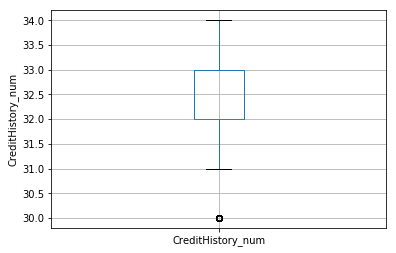

In [43]:
fig = df.boxplot(column='CreditHistory_num')
fig.set_title('')
fig.set_ylabel('CreditHistory_num')

In [44]:
df['CreditHistory_num'].value_counts()

32.0    525
34.0    234
33.0     76
31.0     62
30.0     53
Name: CreditHistory_num, dtype: int64

In [45]:
df['CreditHistory_num'].describe()

count    950.000000
mean      32.395789
std        1.094667
min       30.000000
25%       32.000000
50%       32.000000
75%       33.000000
max       34.000000
Name: CreditHistory_num, dtype: float64

In [46]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 36.0, df[variable])

for df in [X_train, X_test, df]:
    df['CreditHistory_num'] = top_code(df, 'CreditHistory_num', 36.0)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, 29.0, df[variable])

for df in [X_train, X_test, df]:
    df['CreditHistory_num'] = bottom_code(df, 'CreditHistory_num', 29.0)



In [47]:
df['CreditHistory_num'].describe()

count    950.000000
mean      32.395789
std        1.094667
min       30.000000
25%       32.000000
50%       32.000000
75%       33.000000
max       34.000000
Name: CreditHistory_num, dtype: float64

**c) ForeignWorker**

In [48]:
df['ForeignWorker_num'].value_counts()

201.0    926
202.0     24
Name: ForeignWorker_num, dtype: int64

Do not touch this variable


**d) Job_num**

In [49]:
df['Job_num'].value_counts()

173.0    613
172.0    184
174.0    135
171.0     18
Name: Job_num, dtype: int64

Do not touch

**e) Housing_num**

In [50]:
df['Housing_num'].value_counts()

152.0    658
151.0    180
153.0    112
Name: Housing_num, dtype: int64

In [51]:
IQR = df.Housing_num.quantile(0.75) - df.Housing_num.quantile(0.25)
Lower_fence = df.Housing_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Housing_num.quantile(0.75) + (IQR * 3)
print('Housing_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))



Housing_num outliers are values < 152.0 or > 152.0


Do not touch these outliers

**f) OtherDetorsGuarantor_num**

In [52]:
df['OtherDetorsGuarantors_num'].value_counts()

101.0    862
103.0     45
102.0     43
Name: OtherDetorsGuarantors_num, dtype: int64

I will group the two highest categories

In [53]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 102, df[variable])

for df in [X_train, X_test, df]:
    df['OtherDetorsGuarantors_num'] = top_code(df, 'OtherDetorsGuarantors_num', 102)

In [54]:
df['OtherDetorsGuarantors_num'].value_counts()

101.0    862
102.0     88
Name: OtherDetorsGuarantors_num, dtype: int64

**g) Other Installments**

In [55]:
df['OtherInstalments_num'].value_counts()

143.0    783
141.0    128
142.0     39
Name: OtherInstalments_num, dtype: int64

In [56]:
def bottom_code(df, variable, bottom):
    return np.where(df[variable]<=bottom, 141, df[variable])

for df in [X_train, X_test, df]:
    df['OtherInstalments_num'] = bottom_code(df, 'OtherInstalments_num', 142)

In [57]:
df['OtherInstalments_num'].value_counts()

143.0    783
141.0    167
Name: OtherInstalments_num, dtype: int64

**e) Purpose** 

In [58]:
df['Purpose_num'].value_counts()

40.0     254
43.0     254
42.0     153
49.0      96
41.0      84
46.0      44
45.0      32
410.0     11
44.0      11
48.0      11
Name: Purpose_num, dtype: int64

In [59]:
IQR = df.Purpose_num.quantile(0.75) - df.Purpose_num.quantile(0.25)
Lower_fence = df.Purpose_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Purpose_num.quantile(0.75) + (IQR * 3)
print('Purpose_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))



Purpose_num outliers are values < 31.0 or > 52.0


In [60]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 52, df[variable])

for df in [X_train, X_test, df]:
    df['Purpose_num'] = top_code(df, 'Purpose_num', 52)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, 31, df[variable])

for df in [X_train, X_test, df]:
    df['Purpose_num'] = bottom_code(df, 'Purpose_num', 31)



In [61]:
df['Purpose_num'].value_counts()

40.0    254
43.0    254
42.0    153
49.0     96
41.0     84
46.0     44
45.0     32
44.0     11
52.0     11
48.0     11
Name: Purpose_num, dtype: int64

**f) Savings_num**

In [62]:
df['Savings_num'].value_counts()

61.0    618
65.0    146
62.0     95
63.0     54
64.0     37
Name: Savings_num, dtype: int64

In [63]:
IQR = df.Savings_num.quantile(0.75) - df.Savings_num.quantile(0.25)
Lower_fence = df.Savings_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.Savings_num.quantile(0.75) + (IQR * 3)
print('Savings_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


Savings_num outliers are values < 58.0 or > 65.0


In [64]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 65, df[variable])

for df in [X_train, X_test, df]:
    df['Savings_num'] = top_code(df, 'Savings_num', 65)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, 58, df[variable])

for df in [X_train, X_test, df]:
    df['Savings_num'] = bottom_code(df, 'Savings_num', 58)

In [65]:
df['Savings_num'].value_counts()

61.0    618
65.0    146
62.0     95
63.0     54
64.0     37
Name: Savings_num, dtype: int64

**g) SexAndStatus_num**

In [66]:
df['SexAndStatus_num'].value_counts()

93.0    495
92.0    329
94.0     87
91.0     39
Name: SexAndStatus_num, dtype: int64

In [67]:
IQR = df.SexAndStatus_num.quantile(0.75) - df.SexAndStatus_num.quantile(0.25)
Lower_fence = df.SexAndStatus_num.quantile(0.25) - (IQR * 3)
Upper_fence = df.SexAndStatus_num.quantile(0.75) + (IQR * 3)
print('SexAndStatus_num outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


SexAndStatus_num outliers are values < 89.0 or > 96.0


In [68]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 96, df[variable])

for df in [X_train, X_test, df]:
    df['SexAndStatus_num'] = top_code(df, 'SexAndStatus_num', 96)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, 89, df[variable])

for df in [X_train, X_test, df]:
    df['SexAndStatus_num'] = bottom_code(df, 'SexAndStatus_num', 89)

In [69]:
df['SexAndStatus_num'].value_counts()

93.0    495
92.0    329
94.0     87
91.0     39
Name: SexAndStatus_num, dtype: int64

**e) Age**

In [70]:
df['Age'].value_counts()

0.125000    33
0.071429    32
0.142857    30
0.089286    27
0.285714    24
0.178571    23
0.160714    23
0.250000    22
0.214286    22
0.303571    21
0.053571    20
0.232143    20
0.107143    20
0.321429    20
0.196429    20
0.267857    18
0.339286    18
0.375000    17
0.482143    14
0.392857    14
0.357143    14
0.410714    13
0.500000    13
0.446429    13
0.035714    11
0.517857    10
0.428571     9
0.017857     9
0.464286     8
0.642857     8
            ..
0.576663     1
0.695318     1
0.207032     1
0.080063     1
0.515716     1
0.734284     1
0.110770     1
0.072638     1
0.502289     1
0.346262     1
0.092164     1
0.397416     1
0.170459     1
0.403184     1
0.262089     1
0.224889     1
0.157836     1
0.982143     1
0.097748     1
0.216575     1
0.051431     1
0.100209     1
0.122122     1
0.641679     1
0.441316     1
0.112899     1
0.085819     1
0.105934     1
0.236720     1
0.424013     1
Name: Age, Length: 355, dtype: int64

In [71]:
IQR = df.Age.quantile(0.75) - df.Age.quantile(0.25)
Lower_fence = df.Age.quantile(0.25) - (IQR * 3)
Upper_fence = df.Age.quantile(0.75) + (IQR * 3)
print('Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))



Age outliers are values < -0.6724138319999998 or > 1.1918103742499997


In [72]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 1.1918103742499997, df[variable])

for df in [X_train, X_test, df]:
    df['SexAndStatus_num'] = top_code(df, 'SexAndStatus_num', 1.1918103742499997)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, -0.6724138319999998, df[variable])

for df in [X_train, X_test, df]:
    df['SexAndStatus_num'] = bottom_code(df, 'SexAndStatus_num', -0.6724138319999998)

In [73]:
df['Age'].value_counts()

0.125000    33
0.071429    32
0.142857    30
0.089286    27
0.285714    24
0.178571    23
0.160714    23
0.250000    22
0.214286    22
0.303571    21
0.053571    20
0.232143    20
0.107143    20
0.321429    20
0.196429    20
0.267857    18
0.339286    18
0.375000    17
0.482143    14
0.392857    14
0.357143    14
0.410714    13
0.500000    13
0.446429    13
0.035714    11
0.517857    10
0.428571     9
0.017857     9
0.464286     8
0.642857     8
            ..
0.576663     1
0.695318     1
0.207032     1
0.080063     1
0.515716     1
0.734284     1
0.110770     1
0.072638     1
0.502289     1
0.346262     1
0.092164     1
0.397416     1
0.170459     1
0.403184     1
0.262089     1
0.224889     1
0.157836     1
0.982143     1
0.097748     1
0.216575     1
0.051431     1
0.100209     1
0.122122     1
0.641679     1
0.441316     1
0.112899     1
0.085819     1
0.105934     1
0.236720     1
0.424013     1
Name: Age, Length: 355, dtype: int64

**d) CreditAmount**

In [74]:
df['CreditAmount'].value_counts()

0.062892    3
0.067569    3
0.026246    2
0.342137    2
0.010069    2
0.313855    2
0.050567    2
0.054473    2
0.063993    2
0.024816    2
0.055464    2
0.105700    2
0.152250    2
0.025696    2
0.170518    2
0.117420    2
0.045780    2
0.092715    2
0.065973    2
0.062287    2
0.049741    2
0.019753    2
0.039947    2
0.092110    2
0.061296    2
0.183779    2
0.025256    2
0.057060    2
0.068945    2
0.053978    2
           ..
0.036261    1
0.032763    1
0.042501    1
0.115440    1
0.169528    1
0.199296    1
0.076307    1
0.134978    1
0.032519    1
0.040332    1
0.214647    1
0.149609    1
0.236434    1
0.232365    1
0.033895    1
0.165016    1
0.042588    1
0.090404    1
0.202982    1
0.590074    1
0.198470    1
0.328986    1
0.068612    1
0.081985    1
0.276118    1
0.220794    1
0.029713    1
0.305966    1
0.070595    1
0.065093    1
Name: CreditAmount, Length: 914, dtype: int64

In [75]:
IQR = df.CreditAmount.quantile(0.75) - df.CreditAmount.quantile(0.25)
Lower_fence = df.CreditAmount.quantile(0.25) - (IQR * 3)
Upper_fence = df.CreditAmount.quantile(0.75) + (IQR * 3)
print('CreditAmount outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


CreditAmount outliers are values < -0.42554058225 or > 0.7159834115


In [76]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 0.7159834115, df[variable])

for df in [X_train, X_test, df]:
    df['CreditAmount'] = top_code(df, 'CreditAmount', 0.7159834115)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom, -0.42554058225, df[variable])

for df in [X_train, X_test, df]:
    df['CreditAmount'] = bottom_code(df, 'CreditAmount', -0.42554058225)

**e) Duration**

In [77]:
IQR = df.Duration.quantile(0.75) - df.Duration.quantile(0.25)
Lower_fence = df.Duration.quantile(0.25) - (IQR * 3)
Upper_fence = df.Duration.quantile(0.75) + (IQR * 3)
print('Duration outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))



Duration outliers are values < -0.588235292 or > 1.0588235270000002


In [78]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, 0.10588235270000002, df[variable])

for df in [X_train, X_test, df]:
    df['Duration'] = top_code(df, 'Duration', 0.10588235270000002)

def bottom_code(df, variable, bottom):
    return np.where(df[variable]<bottom,  -0.588235292, df[variable])

for df in [X_train, X_test, df]:
    df['Duration'] = bottom_code(df, 'Duration',  -0.588235292)

### 7. Engineer Categorical Variables

#### 7.1 Rare Labels in Categorical Variables (include here numerical ordinal)

In [79]:
# find unfrequent labels in categorical variables
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

CheckingAcctStat_cat A    1.0
Name: CheckingAcctStat_cat, dtype: float64

CreditHistory_cat A    1.0
Name: CreditHistory_cat, dtype: float64

Employment_cat A    1.0
Name: Employment_cat, dtype: float64

ForeignWorker_cat A    1.0
Name: ForeignWorker_cat, dtype: float64

Housing_cat A    1.0
Name: Housing_cat, dtype: float64

Job_cat A    1.0
Name: Job_cat, dtype: float64

OtherDetorsGuarantors_cat A    1.0
Name: OtherDetorsGuarantors_cat, dtype: float64

OtherInstalments_cat A    1.0
Name: OtherInstalments_cat, dtype: float64

Property_cat A    1.0
Name: Property_cat, dtype: float64

Purpose_cat A    1.0
Name: Purpose_cat, dtype: float64

Savings_cat A    1.0
Name: Savings_cat, dtype: float64

SexAndStatus_cat A    1.0
Name: SexAndStatus_cat, dtype: float64

Telephone_cat A    1.0
Name: Telephone_cat, dtype: float64



All the categorical variables I have present only 1 label. Therefore, they add no value and can be eliminated. 

In [80]:
categorical

['CheckingAcctStat_cat',
 'CreditHistory_cat',
 'Employment_cat',
 'ForeignWorker_cat',
 'Housing_cat',
 'Job_cat',
 'OtherDetorsGuarantors_cat',
 'OtherInstalments_cat',
 'Property_cat',
 'Purpose_cat',
 'Savings_cat',
 'SexAndStatus_cat',
 'Telephone_cat']

In [81]:
df= df.drop(['CheckingAcctStat_cat',
 'CreditHistory_cat',
 'Employment_cat',
 'ForeignWorker_cat',
 'Housing_cat',
 'Job_cat',
 'OtherDetorsGuarantors_cat',
 'OtherInstalments_cat',
 'Property_cat',
 'Purpose_cat',
 'Savings_cat',
 'SexAndStatus_cat',
 'Telephone_cat'], axis=1)

#### 7.3.1 Engineer Rare values

From numerical ordinal 

In [82]:
# Now handle numerical ordinal, NumberDependents
cols = ['NumberDependents']
for col in cols:
    print(df.groupby(col)[col].count()/np.float(len(df)))
    print()

NumberDependents
0.000000    0.815789
0.065976    0.005263
0.143863    0.010526
0.856137    0.005263
0.934024    0.010526
1.000000    0.152632
Name: NumberDependents, dtype: float64



In [83]:
print(X_train.groupby('NumberDependents')['NumberDependents'].count()/np.float(len(X_train)))

NumberDependents
0.000000    0.806579
0.065976    0.006579
0.143863    0.009211
0.856137    0.003947
0.934024    0.009211
1.000000    0.164474
Name: NumberDependents, dtype: float64


In [84]:
# find the most frequent category, I will use this line in the below function
frequent_cat = X_train.groupby('NumberDependents')['NumberDependents'].count().sort_values().tail(1).index.values[0]
frequent_cat

0.0

In [85]:
# find the rare label, I will use this line in the below function
temp = X_train.groupby('NumberDependents')['NumberDependents'].count()/np.float(len(X_train))
[x for x in temp.loc[temp<0.05].index.values]

[0.065976486, 0.143862594, 0.856137406, 0.934023514]

Since Rare categories in the variable 'NumberDependents'are less than 10. We do nothing (no imputation or grouping)

### 8. Gaussian Transformation

Algorithms work better when the shape 

In [86]:
X_train.dtypes

Age                          float64
CreditAmount                 float64
CreditStatus                   int64
Duration                     float64
ExistingCreditsAtBank        float64
InstallmentRatePecnt         float64
NumberDependents             float64
PresentResidenceTime         float64
CheckingAcctStat_num         float64
CheckingAcctStat_cat          object
CreditHistory_num            float64
CreditHistory_cat             object
Employment_num               float64
Employment_cat                object
ForeignWorker_num            float64
ForeignWorker_cat             object
Housing_num                  float64
Housing_cat                   object
Job_num                      float64
Job_cat                       object
OtherDetorsGuarantors_num    float64
OtherDetorsGuarantors_cat     object
OtherInstalments_num         float64
OtherInstalments_cat          object
Property_num                 float64
Property_cat                  object
Purpose_num                  float64
P

In [87]:
# let's group again the variables into categorical or numerical
# now considering the newly created variables

def find_categorical_and_numerical_variables(X_train):
    cat_vars = [col for col in X_train.columns if X_train[col].dtypes == 'O']
    num_vars  = [col for col in X_train.columns if X_train[col].dtypes != 'O']
    return cat_vars, num_vars
                 
categorical, numerical = find_categorical_and_numerical_variables(X_train) 

In [88]:
categorical

['CheckingAcctStat_cat',
 'CreditHistory_cat',
 'Employment_cat',
 'ForeignWorker_cat',
 'Housing_cat',
 'Job_cat',
 'OtherDetorsGuarantors_cat',
 'OtherInstalments_cat',
 'Property_cat',
 'Purpose_cat',
 'Savings_cat',
 'SexAndStatus_cat',
 'Telephone_cat']

In [89]:
numerical

['Age',
 'CreditAmount',
 'CreditStatus',
 'Duration',
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'NumberDependents',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'ForeignWorker_num',
 'Housing_num',
 'Job_num',
 'OtherDetorsGuarantors_num',
 'OtherInstalments_num',
 'Property_num',
 'Purpose_num',
 'Savings_num',
 'SexAndStatus_num',
 'Telephone_num']

In [90]:
for var in [
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'NumberDependents',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'ForeignWorker_num',
 'Housing_num',
 'Job_num',
 'OtherDetorsGuarantors_num',
 'OtherInstalments_num',
 'Property_num',
 'Purpose_num',
 'Savings_num',
 'SexAndStatus_num',
 'Telephone_num',
]:
    print(var, 'skewness is', df[var].skew() )

ExistingCreditsAtBank skewness is 1.3310729348320618
InstallmentRatePecnt skewness is -0.6732604256422537
NumberDependents skewness is 1.7723803240549874
PresentResidenceTime skewness is -0.27154628793787455
CheckingAcctStat_num skewness is 0.324403394293832
CreditHistory_num skewness is 0.04254048672051838
Employment_num skewness is -0.04559677032830854
ForeignWorker_num skewness is 6.060130757010168
Housing_num skewness is -0.03802905332277845
Job_num skewness is -0.36766902316678163
OtherDetorsGuarantors_num skewness is 2.814702917127409
OtherInstalments_num skewness is -1.7061930441516497
Property_num skewness is -0.04308641795574535
Purpose_num skewness is 1.2091371551005043
Savings_num skewness is 1.2626891823986097
SexAndStatus_num skewness is 0
Telephone_num skewness is 0.42237154939797195


I will only try to improve the distribution of those numerical variables (not previously discretised), with an absolute skewness value above 1:

- NumberDependents
- OtherInstallments_num
- ForeignWorker_num
- OtherDetorsGuarantors_num
- Purpose_num
- Savings_num

#### Diagnostics

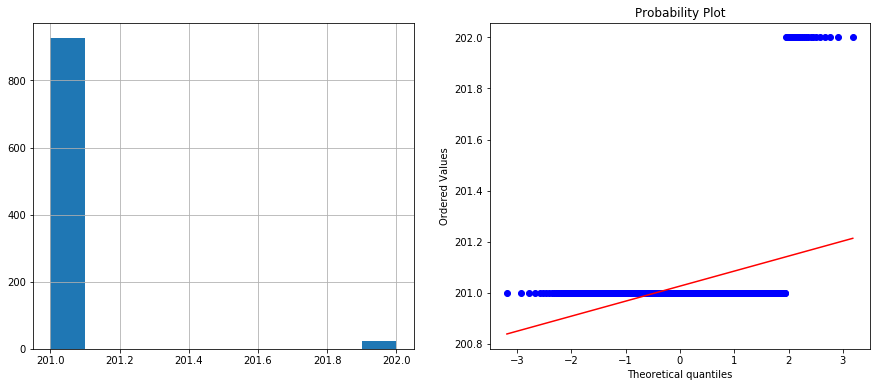

In [91]:
# plot the histograms to have a quick look at the distributions
# we can plot Q-Q plots to visualise if the variable is normally distributed

def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
diagnostic_plots(df, 'ForeignWorker_num')


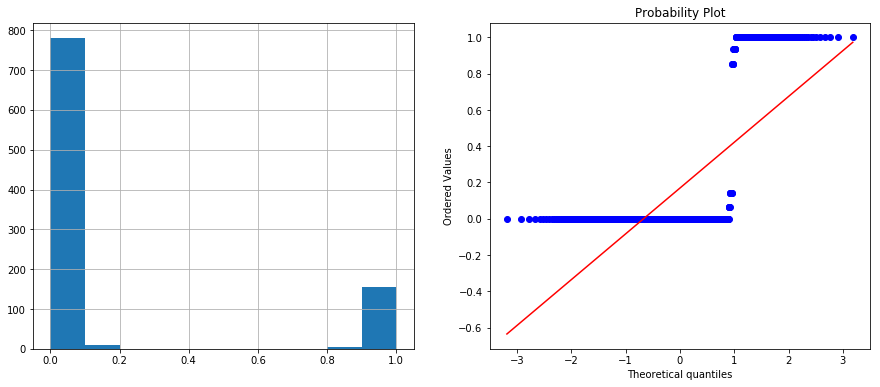

In [92]:
diagnostic_plots(df, 'NumberDependents')

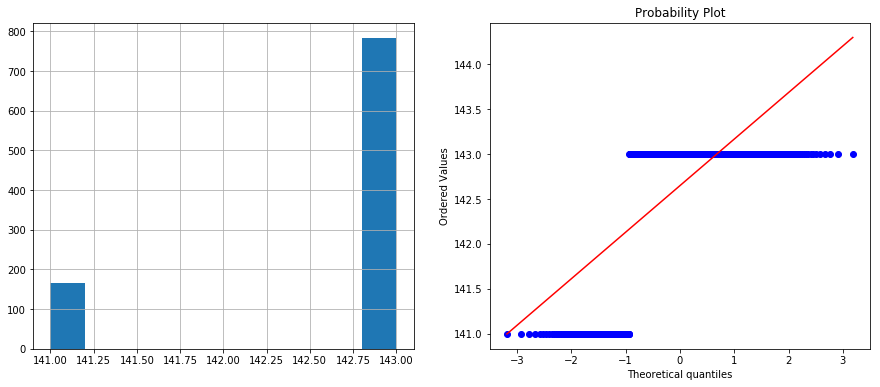

In [93]:
diagnostic_plots(df, 'OtherInstalments_num')

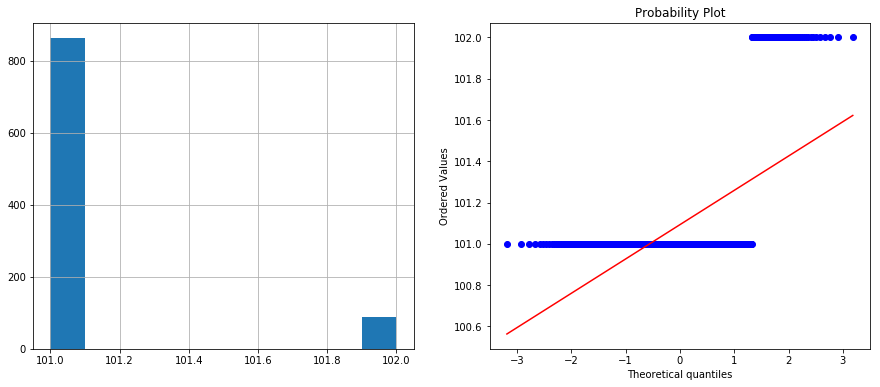

In [94]:
diagnostic_plots(df, 'OtherDetorsGuarantors_num')

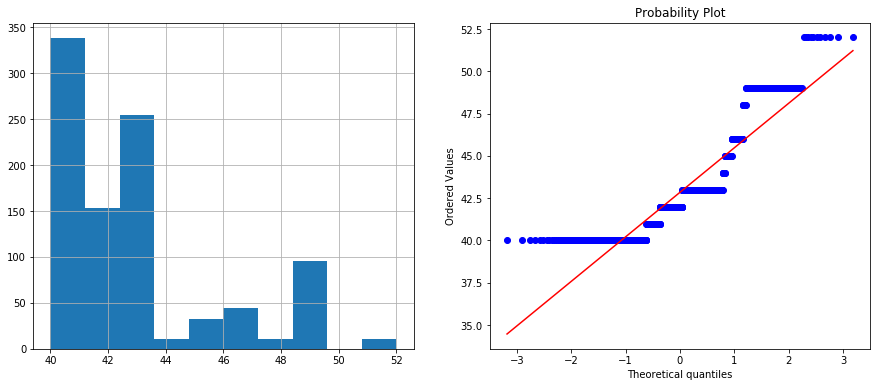

In [95]:
diagnostic_plots(df, 'Purpose_num')

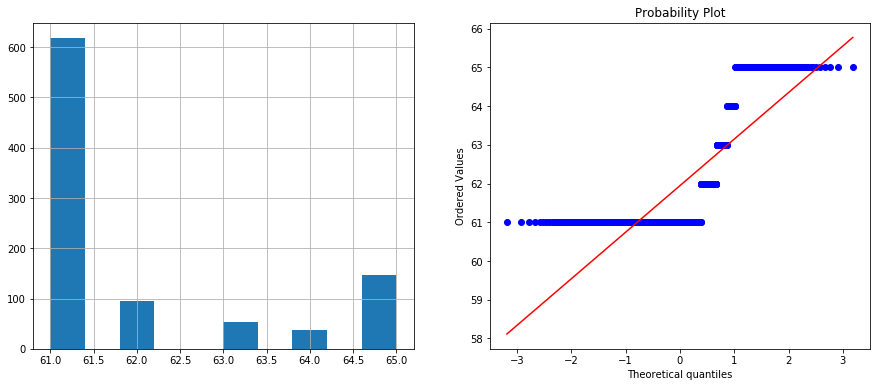

In [96]:
diagnostic_plots(df, 'Savings_num')

I only have chances to improve **Savings_num** and **Purpose_num**, the rest I ignore them


#### a) Purpose_num

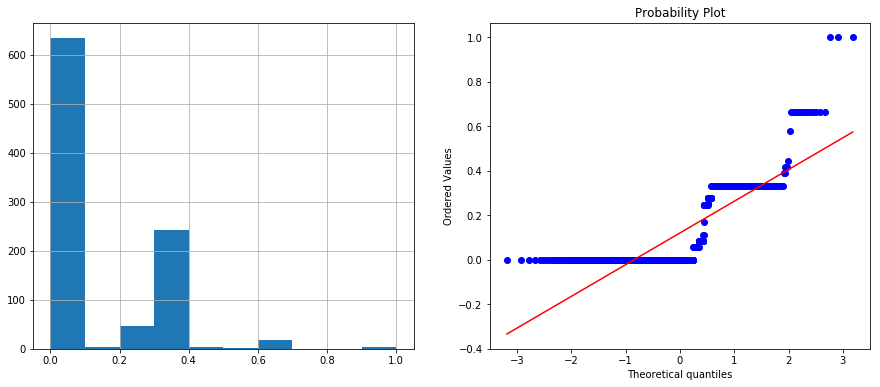

In [97]:
# plot the histograms to have a quick look at the distributions
# we can plot Q-Q plots to visualise if the variable is normally distributed

def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
diagnostic_plots(df, 'ExistingCreditsAtBank')

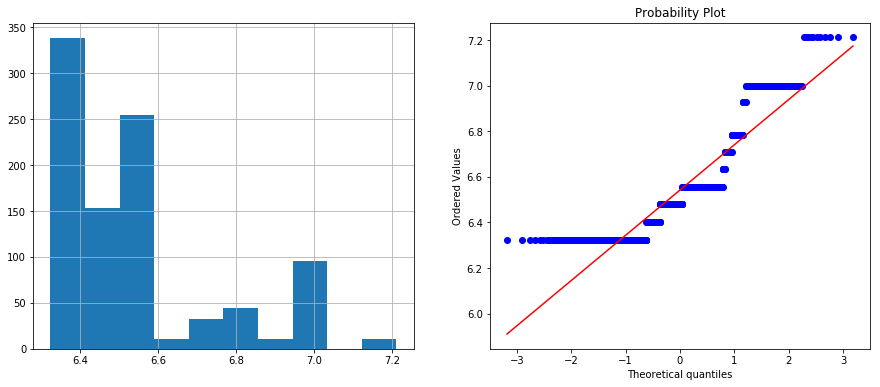

In [98]:
df['Purpose_num_sqrt'] =df.Purpose_num**(1/2)

diagnostic_plots(df, 'Purpose_num_sqrt')

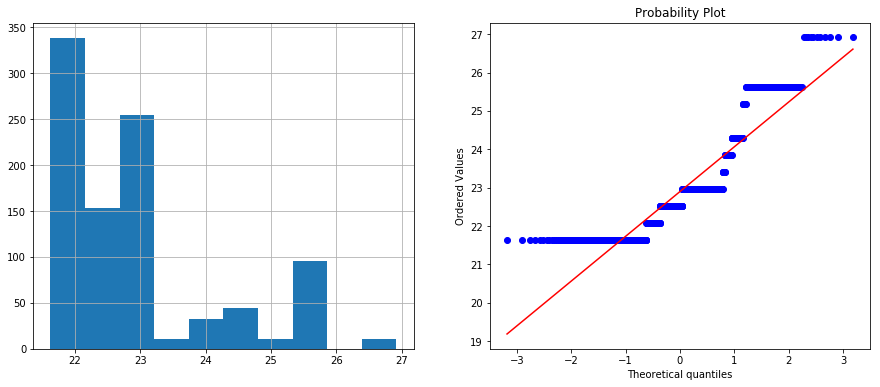

In [99]:
df['Purpose_num_exp'] = df.Purpose_num**(1/1.2) # you can vary the exponent as needed

diagnostic_plots(df, 'Purpose_num_exp')

Non provides an improvement, so I stick to the original variable

In [100]:
#Drop other created variables
df= df.drop(['Purpose_num_sqrt',
       'Purpose_num_exp'], axis=1)

#### b) Savings_num

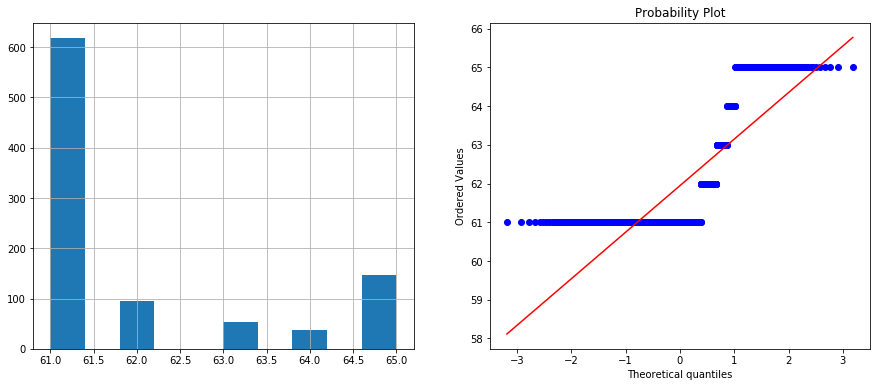

In [101]:
# plot the histograms to have a quick look at the distributions
# we can plot Q-Q plots to visualise if the variable is normally distributed

def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
diagnostic_plots(df, 'Savings_num')

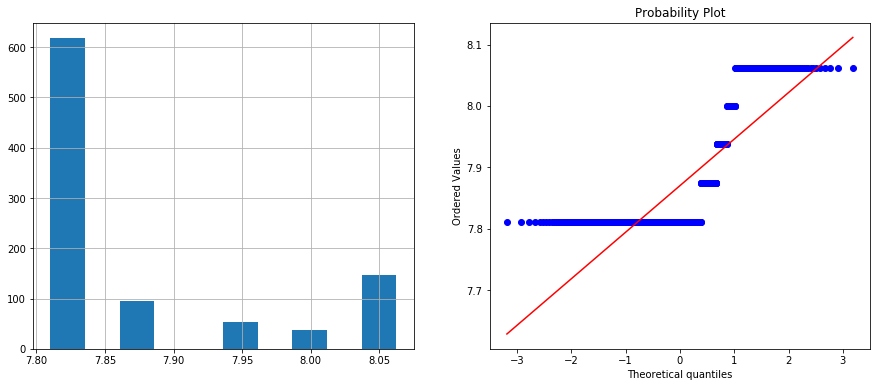

In [102]:
df['Savings_num_sqr'] =df.Savings_num**(1/2)

diagnostic_plots(df, 'Savings_num_sqr')

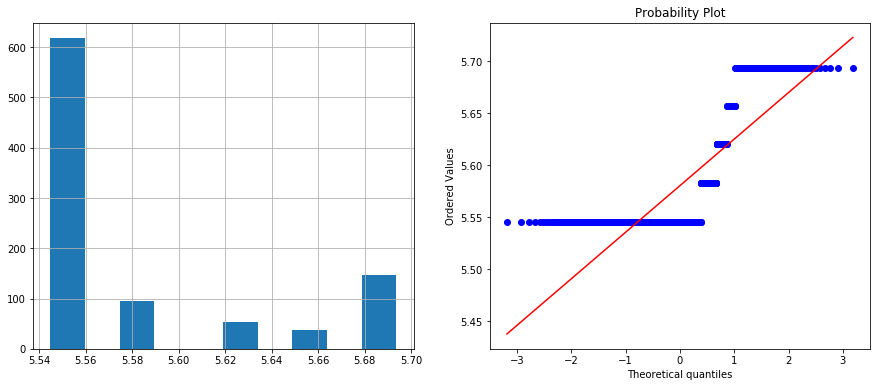

In [103]:
df['Savings_num_sqr_sqr_exp'] = df.Savings_num_sqr**(1/1.2) # you can vary the exponent as needed

diagnostic_plots(df, 'Savings_num_sqr_sqr_exp')

None of them improves the original, so I delete newly created variables

In [104]:
#Drop other created variables
df= df.drop([
       'Savings_num_sqr','Savings_num_sqr_sqr_exp'], axis=1)

### 9. Scaling

I will scale data based on the shape of the variables.

- Most skewed one: Robust Scaling
- Skewed: MinMax
- Other: Standarization

In [105]:
X_train.head()

,Age,CreditAmount,CreditStatus,Duration,ExistingCreditsAtBank,InstallmentRatePecnt,NumberDependents,PresentResidenceTime,CheckingAcctStat_num,CheckingAcctStat_cat,CreditHistory_num,CreditHistory_cat,Employment_num,Employment_cat,ForeignWorker_num,ForeignWorker_cat,Housing_num,Housing_cat,Job_num,Job_cat,OtherDetorsGuarantors_num,OtherDetorsGuarantors_cat,OtherInstalments_num,OtherInstalments_cat,Property_num,Property_cat,Purpose_num,Purpose_cat,Savings_num,Savings_cat,SexAndStatus_num,SexAndStatus_cat,Telephone_num,Telephone_cat
62,0.178571,0.048036,1,0.105882,0.000000,1.0,0.0,1.000000,14.0,A,32.0,A,73.0,A,201.0,A,151.0,A,172.0,A,101.0,A,143.0,A,123.0,A,42.0,A,63.0,A,1.19181,A,191.0,A
79,0.017857,0.018433,0,0.105882,0.333333,1.0,0.0,1.000000,12.0,A,33.0,A,73.0,A,201.0,A,151.0,A,173.0,A,102.0,A,143.0,A,121.0,A,43.0,A,61.0,A,1.19181,A,191.0,A
647,0.399834,0.082563,1,0.105882,0.000000,1.0,1.0,0.364481,11.0,A,32.0,A,75.0,A,201.0,A,152.0,A,173.0,A,101.0,A,143.0,A,123.0,A,42.0,A,61.0,A,1.19181,A,191.0,A
181,0.160714,0.104105,0,0.102941,0.000000,0.0,0.0,0.333333,14.0,A,32.0,A,75.0,A,201.0,A,152.0,A,173.0,A,101.0,A,143.0,A,121.0,A,49.0,A,64.0,A,1.19181,A,192.0,A
304,0.196429,0.411082,0,0.105882,0.000000,0.0,0.0,0.333333,11.0,A,32.0,A,72.0,A,202.0,A,152.0,A,173.0,A,101.0,A,143.0,A,122.0,A,42.0,A,65.0,A,1.19181,A,192.0,A


In [106]:
# I Will start with Robust Scaling
scalerR = RobustScaler() # call the object
X_train_scaledR = scalerR.fit_transform(X_train[['ForeignWorker_num','OtherInstalments_num','OtherDetorsGuarantors_num','NumberDependents']]) # fit the scaler to the train set, and then scale it
X_test_scaledR= scalerR.transform(X_test[['ForeignWorker_num','OtherInstalments_num','OtherDetorsGuarantors_num','NumberDependents']]) # scale the test set

In [107]:
#Continue with MinMax Scaling
scalerMM = MinMaxScaler() # create an instance

X_train_scaledMM= scalerMM.fit_transform(X_train[['Purpose_num','Savings_num']]) #  fit  the scaler to the train set and then transform it
X_test_scaledMM= scalerMM.transform(X_test[['Purpose_num','Savings_num']]) # transform (scale) the test set





In [108]:
# Normal Standarization
scalerN = StandardScaler() # create an object
X_train_scaledN = scalerN.fit_transform(X_train[[
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'Housing_num',
 'Job_num',
 'Property_num',
 'SexAndStatus_num',
 'Telephone_num',
 'Duration',
 'CreditAmount',
 'Age' ]]) # fit the scaler to the train set, and then transform it
X_test_scaledN = scalerN.transform(X_test[[
 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'Housing_num',
 'Job_num',
 'Property_num',
 'SexAndStatus_num',
 'Telephone_num',
 'Duration',
 'CreditAmount',
 'Age']]) # transform the test set

### 10. Put selected variables in one dataset (final)

In [109]:
X_train_scaledR = pd.DataFrame(X_train_scaledR, columns = ['ForeignWorker_num','OtherInstalments_num','OtherDetorsGuarantors_num','NumberDependents'])
X_train_scaledMM = pd.DataFrame(X_train_scaledMM, columns = ['Purpose_num','Savings_num'])
X_train_scaledN = pd.DataFrame(X_train_scaledN, columns = [ 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'Housing_num',
 'Job_num',
 'Property_num',
 'SexAndStatus_num',
 'Telephone_num',
 'Duration',
 'CreditAmount',
 'Age'])

######
X_test_scaledR = pd.DataFrame(X_test_scaledR, columns = ['ForeignWorker_num','OtherInstalments_num','OtherDetorsGuarantors_num','NumberDependents'])
X_test_scaledMM = pd.DataFrame(X_test_scaledMM, columns = ['Purpose_num','Savings_num'])
X_test_scaledN = pd.DataFrame(X_test_scaledN, columns = [ 'ExistingCreditsAtBank',
 'InstallmentRatePecnt',
 'PresentResidenceTime',
 'CheckingAcctStat_num',
 'CreditHistory_num',
 'Employment_num',
 'Housing_num',
 'Job_num',
 'Property_num',
 'SexAndStatus_num',
 'Telephone_num',
 'Duration',
 'CreditAmount',
 'Age'])




In [110]:
X_train = pd.concat([X_train_scaledR, X_train_scaledMM, X_train_scaledN], axis=1)
X_test = pd.concat([X_test_scaledR, X_test_scaledMM, X_test_scaledN], axis=1)



In [111]:
X_train.head()

,ForeignWorker_num,OtherInstalments_num,OtherDetorsGuarantors_num,NumberDependents,Purpose_num,Savings_num,ExistingCreditsAtBank,InstallmentRatePecnt,PresentResidenceTime,CheckingAcctStat_num,CreditHistory_num,Employment_num,Housing_num,Job_num,Property_num,SexAndStatus_num,Telephone_num,Duration,CreditAmount,Age
0,0.0,0.0,0.0,0.0,0.166667,0.50,-0.700199,0.895228,1.083009,1.328505,-0.374168,-0.259305,-1.751225,-1.416062,0.540564,-1.0,-0.812027,0.340686,-0.868190,-0.546315
1,0.0,0.0,1.0,0.0,0.250000,0.00,1.222275,0.895228,1.083009,-0.265282,0.546116,-0.259305,-1.751225,0.152753,-1.392748,-1.0,-0.812027,0.340686,-1.077004,-1.365608
2,0.0,0.0,0.0,1.0,0.166667,0.00,-0.700199,0.895228,-0.684048,-1.062175,-0.374168,1.376145,0.105025,0.152753,0.540564,-1.0,-0.812027,0.340686,-0.624642,0.581641
3,0.0,0.0,0.0,0.0,0.750000,0.75,-0.700199,-1.880746,-0.770654,1.328505,-0.374168,1.376145,0.105025,0.152753,-1.392748,-1.0,1.231485,0.190308,-0.472686,-0.637348
4,1.0,0.0,0.0,0.0,0.166667,1.00,-0.700199,-1.880746,-0.770654,-1.062175,-0.374168,-1.077030,0.105025,0.152753,-0.426092,-1.0,1.231485,0.340686,1.692687,-0.455283


In [112]:
X_train = pd.DataFrame(X_train)
X_train.to_csv('X_train.csv', index=False)

In [113]:
X_test = pd.DataFrame(X_test)
X_test.to_csv('X_test.csv', index=False)

X_test.head()

,ForeignWorker_num,OtherInstalments_num,OtherDetorsGuarantors_num,NumberDependents,Purpose_num,Savings_num,ExistingCreditsAtBank,InstallmentRatePecnt,PresentResidenceTime,CheckingAcctStat_num,CreditHistory_num,Employment_num,Housing_num,Job_num,Property_num,SexAndStatus_num,Telephone_num,Duration,CreditAmount,Age
0,0.0,0.0,0.0,1.0,0.000000,0.00,-0.207647,0.895228,0.654293,-1.062175,-2.214735,1.376145,0.105025,0.152753,-0.426092,-1.0,-0.812027,0.340686,-0.180246,0.505064
1,0.0,-2.0,0.0,0.0,0.250000,0.25,1.222275,0.895228,1.083009,1.328505,1.466399,1.376145,0.105025,0.152753,-0.426092,-1.0,-0.812027,0.340686,-0.441248,1.547433
2,0.0,0.0,0.0,0.0,0.166667,0.00,-0.700199,0.895228,-0.770654,-0.265282,-0.374168,-0.259305,0.105025,-1.416062,0.540564,-1.0,-0.812027,-0.561580,-0.713715,-0.364250
3,0.0,0.0,0.0,0.0,0.250000,0.50,-0.700199,-0.030097,-0.770654,1.328505,-0.374168,1.376145,0.105025,1.721569,0.540564,-1.0,1.231485,0.340686,-0.048461,-0.819413
4,0.0,0.0,1.0,0.0,0.250000,0.25,-0.700199,0.895228,1.083009,-0.265282,-0.374168,-0.259305,-1.751225,0.152753,-0.426092,-1.0,-0.812027,0.340686,-0.127639,-1.274575


In [114]:
y_train = pd.DataFrame(y_train)
y_train.to_csv('y_train.csv', index=False)

y_train.head()

,CreditStatus
62,1
79,0
647,1
181,0
304,0


In [115]:
y_test = pd.DataFrame(y_test)
y_test.to_csv('y_test.csv', index=False)

In [116]:
X_train.isnull().mean()

ForeignWorker_num            0.0
OtherInstalments_num         0.0
OtherDetorsGuarantors_num    0.0
NumberDependents             0.0
Purpose_num                  0.0
Savings_num                  0.0
ExistingCreditsAtBank        0.0
InstallmentRatePecnt         0.0
PresentResidenceTime         0.0
CheckingAcctStat_num         0.0
CreditHistory_num            0.0
Employment_num               0.0
Housing_num                  0.0
Job_num                      0.0
Property_num                 0.0
SexAndStatus_num             0.0
Telephone_num                0.0
Duration                     0.0
CreditAmount                 0.0
Age                          0.0
dtype: float64

In [117]:
X_test.isnull().mean()

ForeignWorker_num            0.0
OtherInstalments_num         0.0
OtherDetorsGuarantors_num    0.0
NumberDependents             0.0
Purpose_num                  0.0
Savings_num                  0.0
ExistingCreditsAtBank        0.0
InstallmentRatePecnt         0.0
PresentResidenceTime         0.0
CheckingAcctStat_num         0.0
CreditHistory_num            0.0
Employment_num               0.0
Housing_num                  0.0
Job_num                      0.0
Property_num                 0.0
SexAndStatus_num             0.0
Telephone_num                0.0
Duration                     0.0
CreditAmount                 0.0
Age                          0.0
dtype: float64

In [118]:
y_train.isnull().mean()

CreditStatus    0.0
dtype: float64

In [119]:
y_test.isnull().mean()

CreditStatus    0.0
dtype: float64